# Eurovision Turing Data Story

Authors
 - Ed Chapman
 - Katriona Goldmann
 - Radka Jersakova
 - David Llewellyn-Jones
 - Joe Palmer
 - Camila Rangel Smith
 - Martin Stoffel
 - Jonathan Yong

We have pooled data from a number of different sources with the aim of understanding trends in the contest voting patterns. We have also tried to make the data as accessible as possible. The curated data frame is available in the `data/df_main.csv` file, and the code to create this dataset is in `data.ipynb`.

![meme comparing what I think I look like discussing eurovision: two men casually talking to sofa; to what I actually look like: Charlie Kelly looking wild-eyed in front of a peg board full of conspiracy connections](eurovision_meme.jpeg)

Our goal is to use this dataset to predict the winners of the [2023 event in Liverpool](https://eurovision.tv/event/liverpool-2023). 

---


We will start by exploring the data we have curated in terms of: 
- voting scores
    - the best performing countries historically
    - countries who's votes deviate from the norm (biases in voting patterns)
    - countries who under- or over-score one another, and countries where the scoring is one sided. 
- migration data
    - information about migration flows between voting-performing pairs and how this affects voting
- Performance language
- Artist gender


We will then build a model to predict the winner of the 2023 contest in a subsequent notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_csv('../../data/df_main.csv')

df.head()

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
0,1998,Danijela,belgium,croatia,5,131,5.0,BE,BEL,HR,...,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42,False
1,1998,Michael Hajiyanni,belgium,cyprus,2,37,11.0,BE,BEL,CY,...,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42,False
2,1998,Koit Toome,belgium,estonia,0,36,12.0,BE,BEL,EE,...,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42,False
3,1998,Vlado Janevski,belgium,north macedonia,0,16,19.0,BE,BEL,MK,...,male,NaN,NaN,NaN,120.0,10136811.0,0.000012,1995.0,42,False
4,1998,Edea,belgium,finland,0,22,15.0,BE,BEL,FI,...,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42,False


# Voting Scores

## The Best Performing Countries

Lets determine the winners each year

In [3]:
winners = df.loc[df['rank'] == 1, ['to_country', 'total_points', 'rank', 'to_code2', 'year']]
winners = winners.drop_duplicates()

winners

,to_country,total_points,rank,to_code2,year
10,israel,172,1.0,IL,1998
618,sweden,163,1.0,SE,1999
1109,denmark,195,1.0,DK,2000
1660,estonia,198,1.0,EE,2001
2176,latvia,176,1.0,LV,2002
2737,turkey,167,1.0,TR,2003
3362,ukraine,280,1.0,UA,2004
4188,greece,230,1.0,GR,2005
5098,finland,292,1.0,FI,2006
5998,serbia,268,1.0,RS,2007


The countries who have won multiple times in this time frame are:

In [4]:
winners['to_country'].value_counts().loc[winners['to_country'].value_counts() > 1]

ukraine    3
sweden     3
israel     2
denmark    2
Name: to_country, dtype: int64

These are the countries with the best average score (though we only count countries who have participated at least 5 times in the finals).

In [5]:
temp = df[['to_country', 'to_code2', 'total_points', 'year']].drop_duplicates()

(temp.groupby('to_country')['total_points']
 .agg(['count', 'mean'])
 .query('count >= 5')
 .sort_values(by='mean', ascending=False)
 .head())

,count,mean
to_country,,
italy,11,170.545455
bulgaria,5,166.400000
ukraine,17,156.647059
russian federation,19,153.473684
sweden,23,142.043478


In [6]:
my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: y / 26


def plot_country(code, ax, df_plot):
    df_temp = df_plot.loc[df_plot['to_code2'] == code]

    df_temp = df_temp.sort_values('year', ascending=False)    

    country_name = df_temp['to_country'].iloc[0].title()

    # for year in 1997 - 2022 not in df_temp['year'] add a row
    for i in range(1997, 2022):
        if (i not in df_temp['year'].values):
            df_add = pd.DataFrame(dict(year= i, total_points= np.nan, 
                        rank= np.nan, to_code2= code, to_country= country_name), 
                        index=[0])
            df_temp = pd.concat([df_temp, df_add], ignore_index=True)

    ax.bar(df_temp['year'], df_temp['total_points'], 
            color=my_cmap(rescale(df_temp['rank'])))

    ax.scatter(2020, 10, s=25, color='grey', marker="_")

    # annotate if nan (did not perform)
    for i, v in enumerate(df_temp.loc[df_temp['year'] != 2020, 'total_points']):
        if np.isnan(v):
            ax.scatter(df_temp['year'].iloc[i], 10, s=25, color='grey', marker="x")


    winner = df_temp.loc[df_temp['rank'] == 1, ['year', 'total_points']]
    winner = winner.drop_duplicates()
    if winner.shape[0] > 0:
        ax.scatter(winner['year'], winner['total_points'], s=50, 
                    color='gold', marker="*", edgecolor='black', zorder=5)

    ax.set_xlim(1997, 2023)
    ax.set_title(country_name)


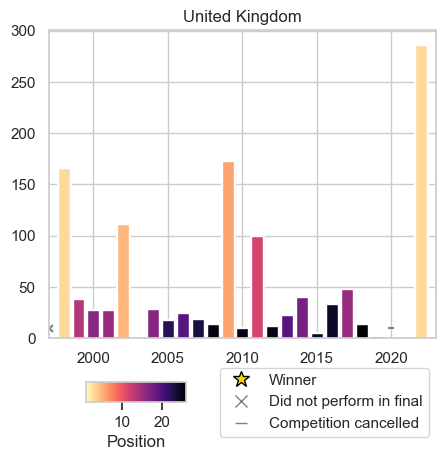

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True, sharex=True, squeeze=True)

plot_country('GB', ax, df)

legend_elements = [Line2D([0], [0], marker='*', color='white', label='Winner',
                          markerfacecolor='gold', markersize=12, markeredgecolor='black'),                          
                  Line2D([0], [0], marker='x', color='white', label='Did not perform in final',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey'), 
                  Line2D([0], [0], marker='_', color='white', label='Competition cancelled',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey')]
fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.2, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)

Text(0.5, 1.0, 'Yugoslavia\nor, Serbia and Montenegro')

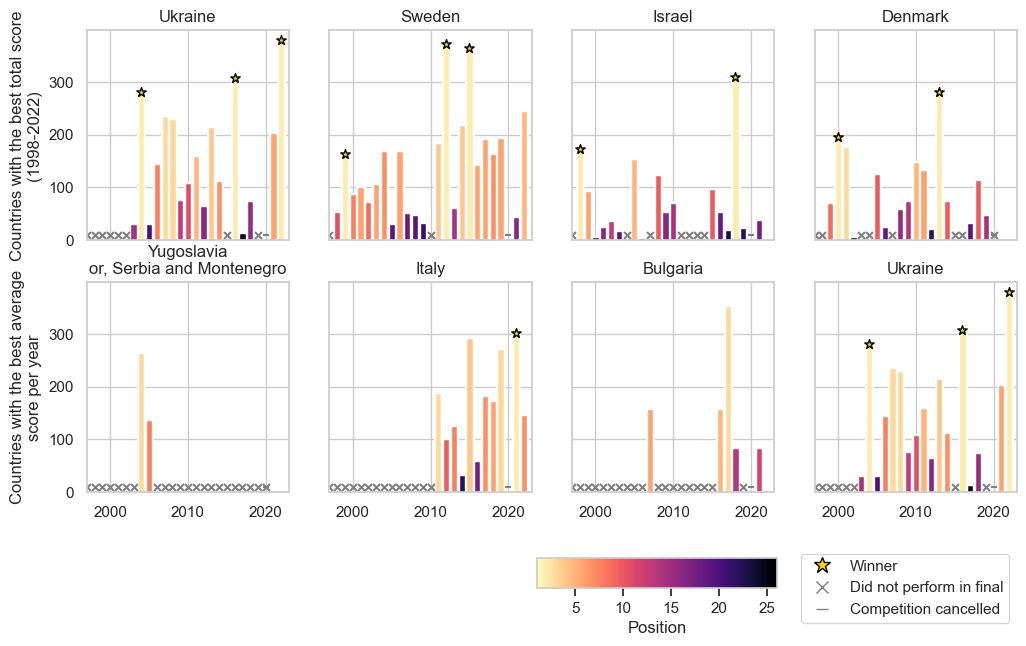

In [8]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True, squeeze=True)

plot_countries = winners['to_code2'].value_counts().loc[winners['to_code2'].value_counts() > 1].index

# add text for second row title
ax[0, 0].text(-0.3, 0.5, 'Countries with the best total score\n(1998-2022)', 
                  horizontalalignment='center', verticalalignment='center', 
                  transform=ax[0, 0].transAxes, fontsize=12, rotation=90)
ax[1, 0].text(-0.3, 0.5, 'Countries with the best average\nscore per year', 
                  horizontalalignment='center', verticalalignment='center', 
                  transform=ax[1, 0].transAxes, fontsize=12, rotation=90)

for i in range(len(plot_countries)): 
    plot_country(plot_countries[i], ax[0, i], df)

plot_countries = temp.groupby('to_code2')['total_points'].mean().sort_values(ascending=False).index[:4]
for i in range(len(plot_countries)): 
    plot_country(plot_countries[i], ax[1, i], df)

fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.5, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)

ax[1][0].set_title("Yugoslavia\nor, Serbia and Montenegro")


## Voting Country Deviations from Average Performance Scores

Calculate the voting deviations from the mean each country receives. 

In [9]:
df_voting= df[['from_country', 'points', 'to_country', 'year']].copy()

# The average votes for each To country
df_voting['avg_votes_per_pcountry'] = df_voting.groupby(['to_country'])['points'].transform('mean')

# The average votes for each To country
df_voting['avg_votes_per_pcountry_per country'] = df_voting.groupby(['to_country', 'from_country'])['points'].transform('mean')

# For each voting instance calculate the deviation from the average votes
df_voting['avg_difference_votes'] = df_voting['avg_votes_per_pcountry_per country'] - df_voting['avg_votes_per_pcountry']    

# If no_instances < 3, set avg_difference_votes to NaN, since this is not a reflective sample
df_voting['no_instances'] = df_voting.groupby(['from_country', 'to_country'])['avg_difference_votes'].transform('count')
df_voting.loc[df_voting['no_instances'] < 3, 'avg_difference_votes'] = np.nan

df_voting.head()

,from_country,points,to_country,year,avg_votes_per_pcountry,avg_votes_per_pcountry_per country,avg_difference_votes,no_instances
0,belgium,5,croatia,1998,2.050725,0.833333,-1.217391,12
1,belgium,2,cyprus,1998,1.766667,1.200000,-0.566667,15
2,belgium,0,estonia,1998,2.624729,1.076923,-1.547806,13
3,belgium,0,north macedonia,1998,1.764901,0.000000,-1.764901,9
4,belgium,0,finland,1998,1.706009,1.461538,-0.244470,13


In [10]:
df_voting_heatmap = df_voting[['from_country', 'avg_difference_votes', 'to_country']]
df_voting_heatmap = df_voting_heatmap.drop_duplicates()

# if from country = to country, set avg_difference_votes to NaN
df_voting_heatmap.loc[df_voting_heatmap['from_country'] == df_voting_heatmap['to_country'], 'avg_difference_votes'] = np.nan

df_voting_heatmap = df_voting_heatmap.dropna(subset=['avg_difference_votes'])

df_heatmap = df_voting_heatmap.pivot(index='from_country', columns='to_country', values='avg_difference_votes')

df_heatmap.head()

to_country,albania,armenia,australia,austria,azerbaijan,belarus,belgium,bosnia and herzegovina,bulgaria,croatia,...,russian federation,san marino,serbia,slovenia,spain,sweden,switzerland,turkey,ukraine,united kingdom
from_country,,,,,,,,,,,,,,,,,,,,,
albania,NaN,-1.716775,-0.929752,-1.768099,-0.630292,-0.970085,-2.430751,2.812081,1.301478,-0.907867,...,-1.621569,2.719298,-1.439975,-1.269663,1.957285,-1.327451,0.975210,5.600664,-2.128149,0.447851
andorra,-1.738579,-2.625866,NaN,NaN,NaN,NaN,NaN,-2.521253,NaN,-2.050725,...,-1.954902,NaN,NaN,NaN,8.568396,-1.200000,NaN,-2.774336,1.434351,-0.441038
armenia,-1.738579,NaN,-2.763085,-0.982385,-2.847075,2.529915,-1.347418,-1.521253,-1.098522,-1.650725,...,6.166310,NaN,-1.248056,-1.269663,0.139825,-0.802564,0.432353,-2.474336,1.934351,-0.798181
australia,-1.738579,-2.625866,NaN,-2.232385,-2.937984,NaN,2.119249,NaN,0.151478,NaN,...,-1.288235,NaN,-0.636945,-1.269663,0.996968,2.538095,2.165686,NaN,1.334351,1.558962
austria,1.404278,0.088420,0.570248,NaN,-0.937984,-0.703419,-0.953478,6.228747,0.101478,2.949275,...,-1.645378,-0.614035,3.307499,-0.602996,-1.098270,0.022222,1.707353,2.350664,-1.527187,-0.107704


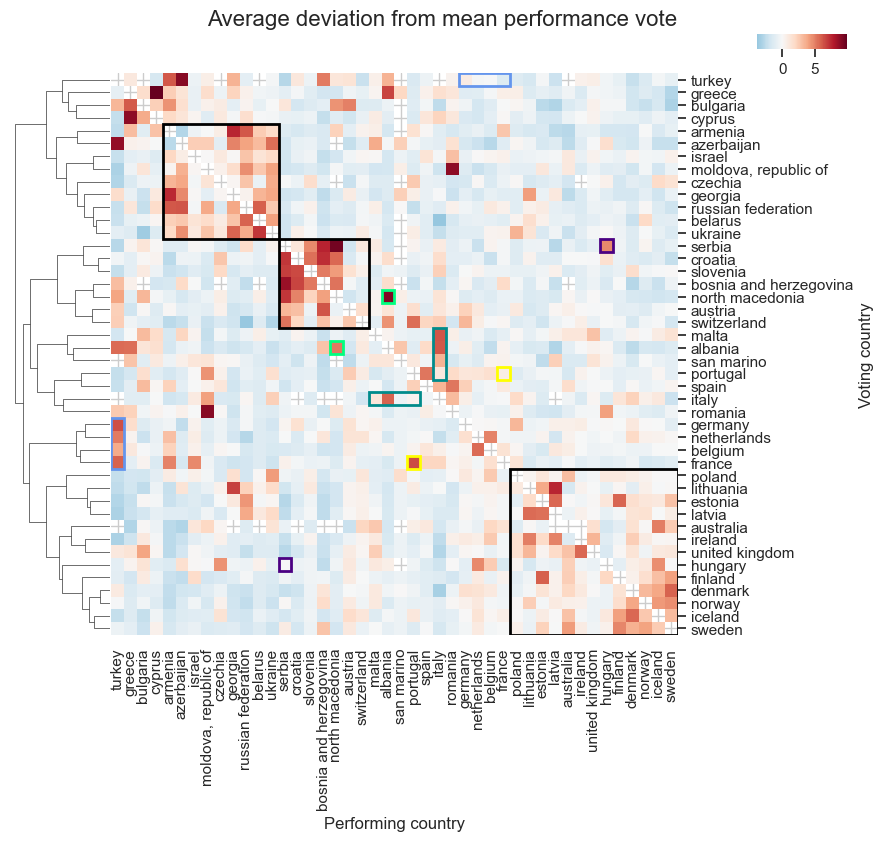

In [11]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

df_heatmap2 = df_heatmap.copy()

# row order to match column order
df_heatmap2 = df_heatmap2.reindex(df_heatmap2.columns)

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')

plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=row_linkage, 
                figsize=(9,8), mask=df_heatmap2.isnull(), 
                dendrogram_ratio= [0.15, 0.01],
                cbar_pos = (0.85,1,0.1,.019), # x,y, delta x, delta y
                cbar_kws={"orientation": "horizontal"},
                cmap='RdBu_r', center=0, xticklabels=1, yticklabels=1)

plot.ax_col_dendrogram.set_visible(False) 

from matplotlib.patches import Rectangle
ax = plot.ax_heatmap

ax.add_patch(Rectangle((4, 4), 9, 9, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((df_heatmap2.shape[1]-13, df_heatmap2.shape[1]-13), 13, 13, fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((13, 13), 7, 7, fill=False, edgecolor='black', lw=2))

ax.add_patch(Rectangle((0, 27), 1, 4, fill=False, edgecolor='cornflowerblue', lw=2)) # turkey-germany, netherlands, belgium, france
ax.add_patch(Rectangle((27, 0), 4, 1, fill=False, edgecolor='cornflowerblue', lw=2))

ax.add_patch(Rectangle((20, 25), 4, 1, fill=False, edgecolor='darkcyan', lw=2)) # italy-malta, san marino, albania, portugal
ax.add_patch(Rectangle((25, 20), 1, 4, fill=False, edgecolor='darkcyan', lw=2))

ax.add_patch(Rectangle((13, 38), 1, 1, fill=False, edgecolor='indigo', lw=2)) # serbia-hungary
ax.add_patch(Rectangle((38, 13), 1, 1, fill=False, edgecolor='indigo', lw=2))

ax.add_patch(Rectangle((21, 17), 1, 1, fill=False, edgecolor='springgreen', lw=2)) # north-macedonia-albania
ax.add_patch(Rectangle((17, 21), 1, 1, fill=False, edgecolor='springgreen', lw=2))

ax.add_patch(Rectangle((30, 23), 1, 1, fill=False, edgecolor='yellow', lw=2)) # portugal-france
ax.add_patch(Rectangle((23, 30), 1, 1, fill=False, edgecolor='yellow', lw=2))

plot.fig.suptitle('Average deviation from mean performance vote', fontsize=16, y=1.05)
plot.ax_heatmap.set_ylabel('Voting country')
plot.ax_heatmap.set_xlabel('Performing country')

plt.show()

## Voting Pair Plots

In [12]:
countries = df['from_country'].unique()

# Create a new dataframe containing the data for the scatter plot
votes = pd.DataFrame({'performer': [], 'voter': [], 'times_competed': [], 'times_voted': [], 'total_points': [], 'average_points': []})

# Compare every country with every other country
for performer in countries:
    times_competed = len(df.loc[df['to_country'] == performer]['year'].unique())
    for voter in countries:
        times_voted = len(df.loc[(df['to_country'] == performer) & (df['from_country'] == voter) & (df['points'] > 0)])
        total_points = df.loc[(df['to_country'] == performer) & (df['from_country'] == voter)]['points'].sum()
        average_points = df.loc[(df['to_country'] == performer) & (df['points'] >= 0) & (df['from_country'] == voter)]['points'].mean()
        votes.loc[len(votes)] = [performer, voter, times_competed, times_voted, total_points, average_points]
print('Check every country is matched with very other: {}'.format(len(countries)**2 == len(votes)))

Check every country is matched with very other: True


<Axes: xlabel='total_points', ylabel='average_points'>

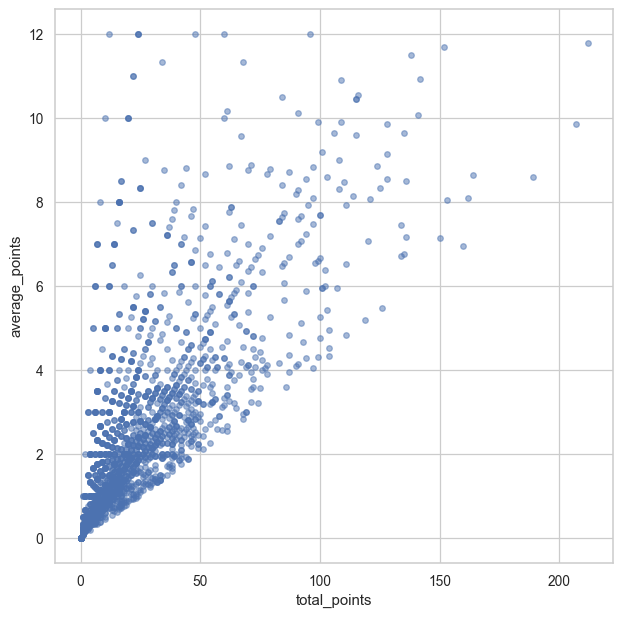

In [13]:
# Render a basic static scatter plot
fig = plt.figure(figsize=(8, 8), dpi=90)
votes.plot.scatter(x='total_points', y='average_points', alpha=0.5, ax = plt.gca())

In [14]:
import plotly.express as px

# Render an interactive (hoverable) plot
fig = px.scatter(votes, x='total_points', y='average_points')
fig.update_traces(hovertemplate='Performer: %{customdata[0]}'
                  + '<br>Voter: %{customdata[1]}'
                  + '<br>Total Eurovisions competed: %{customdata[2]}'
                  + '<br>Total times voted for by selected country: %{customdata[3]}'
                  + '<br>Total points given: %{customdata[4]}'
                  + '<br>Average points: %{customdata[5]:.2f}',
                  customdata=votes,
                  marker={'color': 'rgba(50, 50, 150, 0.1)', 'opacity': 0.5, 'size': 6,
                          'line': {'color': 'rgba(50, 50, 150, 1.0)', 'width': 1}})
fig.update_layout(hoverlabel_align='left', width=640, height=640, margin=dict(l=20, r=20, t=20, b=20),
                  xaxis={'title': 'Total voter points given to specific country'},
                  yaxis={'title': 'Average points'})
fig.show()

## Looking for Country Friendships, Biases, and One-sided relationships

In [15]:
# how often did each country participate?
n_participations = df.groupby('to_country')['year'].nunique().sort_values(ascending=True)
# filter countries with fewer than 3 and turn into list
countries_to_remove = n_participations[n_participations < 3].index.tolist()
# remove from df
df_pairs = df[~df['to_country'].isin(countries_to_remove)]
df_pairs

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
0,1998,Danijela,belgium,croatia,5,131,5.0,BE,BEL,HR,...,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42,False
1,1998,Michael Hajiyanni,belgium,cyprus,2,37,11.0,BE,BEL,CY,...,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42,False
2,1998,Koit Toome,belgium,estonia,0,36,12.0,BE,BEL,EE,...,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42,False
3,1998,Vlado Janevski,belgium,north macedonia,0,16,19.0,BE,BEL,MK,...,male,NaN,NaN,NaN,120.0,10136811.0,0.000012,1995.0,42,False
4,1998,Edea,belgium,finland,0,22,15.0,BE,BEL,FI,...,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21305,2022,Konstrakta,united kingdom,serbia,0,169,5.0,GB,GBR,RS,...,female,658.0,6899126.0,0.000095,9343.0,67081000.0,0.000139,2020.0,13,False
21306,2022,Chanel,united kingdom,spain,8,282,3.0,GB,GBR,ES,...,female,303193.0,47365655.0,0.006401,150892.0,67081000.0,0.002249,2020.0,51,False
21307,2022,Cornelia Jakobs,united kingdom,sweden,10,245,4.0,GB,GBR,SE,...,female,29715.0,10353442.0,0.002870,35824.0,67081000.0,0.000534,2020.0,5,False
21308,2022,Marius Bear,united kingdom,switzerland,0,28,18.0,GB,GBR,CH,...,male,45951.0,8638167.0,0.005320,23649.0,67081000.0,0.000353,2020.0,32,False


In [16]:
df_pairs = (df_pairs
    .groupby(['from_country', 'to_country'])
    #.agg({'votes': 'mean'})
    .agg(votes = ('points', 'mean'), num_years = ('year', 'count'))
    .reset_index()
    .sort_values('votes', ascending=False)
)

df_pairs = (df_pairs
    .merge(df_pairs.rename(columns={'from_country': 'to_country', 
                               'to_country': 'from_country'}), 
           on=['from_country', 'to_country', 'num_years'])
    .drop_duplicates()
    # remove rows where from_country == country
    .query('from_country != to_country')
    # calculate the absolute difference in votes
    .assign(votes_diff = lambda x: abs(x['votes_x'] - x['votes_y']))
    # re-order num_years column before votes_x
    .reindex(columns=['from_country', 'to_country', 'num_years', 'votes_x', 'votes_y', 'votes_diff'])
)



# from_country and country contain same pairs, but in different orders
# make combined column with pairs in alphabetical order
df_pairs['country_pair'] = df_pairs[['from_country', 'to_country']].apply(lambda x: ' - '.join(sorted(x)), axis=1)
# remove duplicate country pairs
df_pairs = df_pairs.drop_duplicates(subset=['country_pair'])
# remove country_pair column
df_pairs = df_pairs.drop(columns=['country_pair'])

df_pairs.head()

,from_country,to_country,num_years,votes_x,votes_y,votes_diff
0,bosnia and herzegovina,serbia,6,11.333333,10.166667,1.166667
2,russian federation,azerbaijan,11,9.181818,8.272727,0.909091
3,turkey,armenia,5,8.800000,0.800000,8.000000
5,switzerland,portugal,8,7.875000,3.000000,4.875000
6,spain,italy,11,7.636364,1.090909,6.545455


In [17]:
N=5

top_lovers = (df_pairs
    .query('votes_diff < 3')
    .sort_values('votes_x', ascending=False).head(N)
)

top_haters = (df_pairs
    .query('votes_diff < 3')
    .sort_values('votes_x', ascending=True).head(N)
)

top_unequals = (df_pairs
            .sort_values('votes_diff', ascending=False).head(N))


# combine top_lovers, top_haters and top_unequals into one df with a new column for type of relationship
top_relationships = (pd.concat([top_lovers, top_haters, top_unequals]))
# add group column first five rows are lovers, next five are haters, next five are unequals
top_relationships['group'] = ['lovers'] * N + ['haters'] * N + ['unequals'] * N

# sort by votes_x
top_relationships = top_relationships.sort_values('votes_x')

top_relationships['y'] = range(1, len(top_relationships) + 1)

top_relationships

,from_country,to_country,num_years,votes_x,votes_y,votes_diff,group,y
166,georgia,albania,7,0.428571,0.000000,0.428571,haters,1
162,serbia,turkey,5,0.600000,0.000000,0.600000,haters,2
148,azerbaijan,australia,6,0.833333,0.000000,0.833333,haters,3
149,belgium,croatia,12,0.833333,0.500000,0.333333,haters,4
147,finland,albania,10,0.900000,0.300000,0.600000,haters,5
14,san marino,latvia,3,5.333333,0.000000,5.333333,unequals,6
12,sweden,bosnia and herzegovina,13,5.384615,3.538462,1.846154,lovers,7
11,turkey,georgia,4,5.500000,5.000000,0.500000,lovers,8
10,slovenia,north macedonia,8,6.000000,3.500000,2.500000,lovers,9
8,france,italy,11,6.454545,1.454545,5.000000,unequals,10


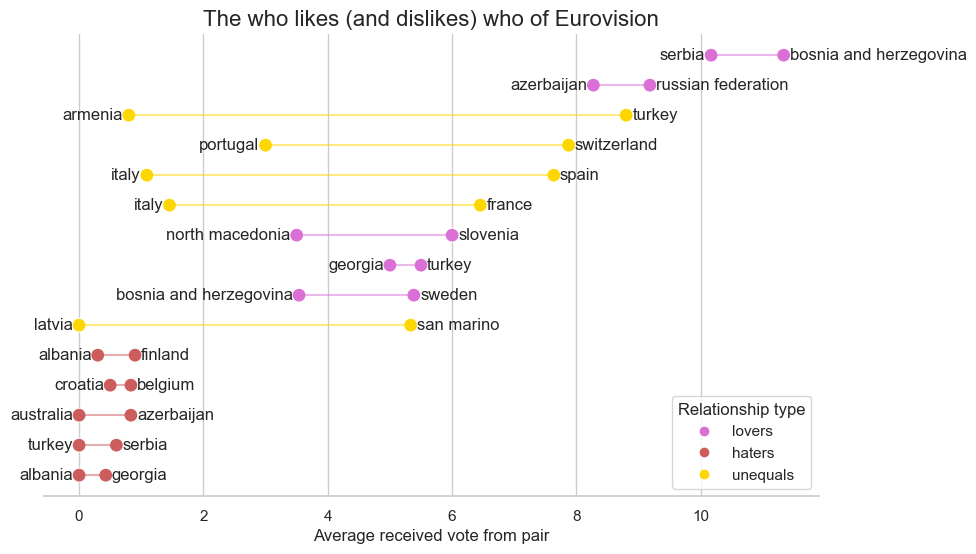

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

colour_dict = {'lovers': 'orchid', 'haters': 'indianred', 'unequals': 'gold'}
color_map =  [colour_dict[i] for i in top_relationships['group']]

# add text labels
for i, row in top_relationships.iterrows():
    ax.text(row['votes_x']+0.1, row['y'] ,row['from_country'],  ha='left', va='center', fontsize=12)
    ax.text(row['votes_y']-0.1, row['y'] , row['to_country'],  ha='right', va='center', fontsize=12)

    # add line between countries
    ax.plot([row['votes_x'], row['votes_y']], [row['y'], row['y']], color=colour_dict[row['group']], alpha=0.5)

sns.scatterplot(data=top_relationships, x='votes_x', y='y', c=color_map, ax=ax, s=100, alpha=1)
sns.scatterplot(data=top_relationships, x='votes_y', y='y', c=color_map, ax=ax, s=100, alpha=1)

ax.set_xlabel('Average received vote from pair')
ax.set_ylabel('')

# Hide the y axis
ax.get_yaxis().set_visible(False)
ax.spines[['top', 'right', 'left']].set_visible(False)

markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in colour_dict.values()]
plt.legend(markers, colour_dict.keys(), numpoints=1, loc='lower right', title='Relationship type')

plt.title('The who likes (and dislikes) who of Eurovision', fontsize=16)

plt.show()


Note: the reason these results look different to the heatmap above is because this is looking at the raw votes, not the deviations from mean. Therefore it could be a genuine effect that turkey perform much better than armenia, therefore the voting is one-sided.

# Migration Data

In [19]:
df.head()

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border
0,1998,Danijela,belgium,croatia,5,131,5.0,BE,BEL,HR,...,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42,False
1,1998,Michael Hajiyanni,belgium,cyprus,2,37,11.0,BE,BEL,CY,...,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42,False
2,1998,Koit Toome,belgium,estonia,0,36,12.0,BE,BEL,EE,...,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42,False
3,1998,Vlado Janevski,belgium,north macedonia,0,16,19.0,BE,BEL,MK,...,male,NaN,NaN,NaN,120.0,10136811.0,0.000012,1995.0,42,False
4,1998,Edea,belgium,finland,0,22,15.0,BE,BEL,FI,...,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42,False


In [20]:
df_migration = df[['year', 'from_code2', 'to_code2', 'prop_emigrants_v2p', 'prop_emigrants_p2v', 'points']].copy()

# Calculate score deviation per year
df_migration['avg_votes'] = df_migration.groupby(['to_code2', 'year'])['points'].transform('mean')
df_migration['deviation'] = df_migration['points'] - df_migration['avg_votes']


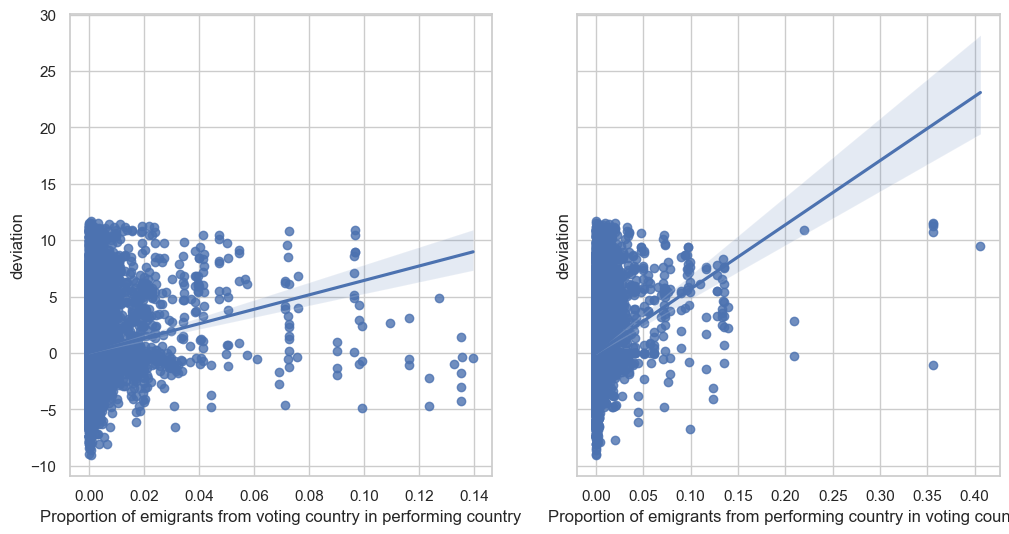

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))
sns.regplot(x='prop_emigrants_v2p', y='deviation', data=df_migration, ax=ax1)
sns.regplot(x='prop_emigrants_p2v', y='deviation', data=df_migration, ax=ax2)

ax1.set_xlabel('Proportion of emigrants from voting country in performing country')
ax2.set_xlabel('Proportion of emigrants from performing country in voting country')

plt.show()

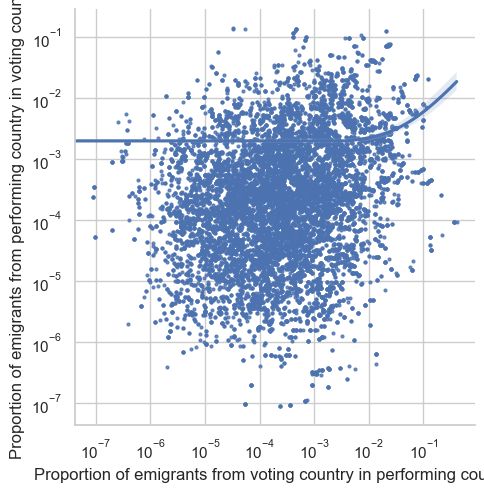

In [22]:
sns.lmplot(x='prop_emigrants_p2v', y='prop_emigrants_v2p', data=df_migration, scatter_kws={"s": 4})

# log scale axes
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Proportion of emigrants from voting country in performing country")
plt.ylabel("Proportion of emigrants from performing country in voting country")
plt.show()

# Language Data

We are interested in three things:
1. Does the song contain english lyrics: yes vs no  :heavy_check_mark:
2. What are the average votes for songs with english lyrics vs non-english lyrics :heavy_check_mark:
3. Does the performer sing in their official language yes vs no (english) vs no (non-english) :heavy_check_mark:
4. How many languages appear in the song vs votes? (can you hedge your bets?) :heavy_check_mark:
5. Are the votes received affected by whether or not a song is sung in the voting country's official language? :heavy_check_mark:

In [23]:
df_performance = df[['year', 'Artist', 'to_country', 
       'total_points', 'rank', 'to_code2',
       'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender']].drop_duplicates()

In [24]:
df_language = df_performance.copy()

df_performance['English_only'] = (df_performance['Contains_English']) & (df_performance['Number_of_Languages'] == 1 )
df_performance['No_English'] = ~df_performance['Contains_English'] 
df_performance['Some_English'] = (df_performance['Contains_English']) & (df_performance['Number_of_Languages'] > 1 )

# for each country get the ratio of songs that contain only English, some English and no English
# then sort by the ratio of songs that contain only English
df_language = df_performance.groupby('to_country').agg({'English_only': 'mean', 'Some_English': 'mean', 'No_English': 'mean'})

df_language = df_language.sort_values(by=['English_only', 'Some_English'], ascending=True)

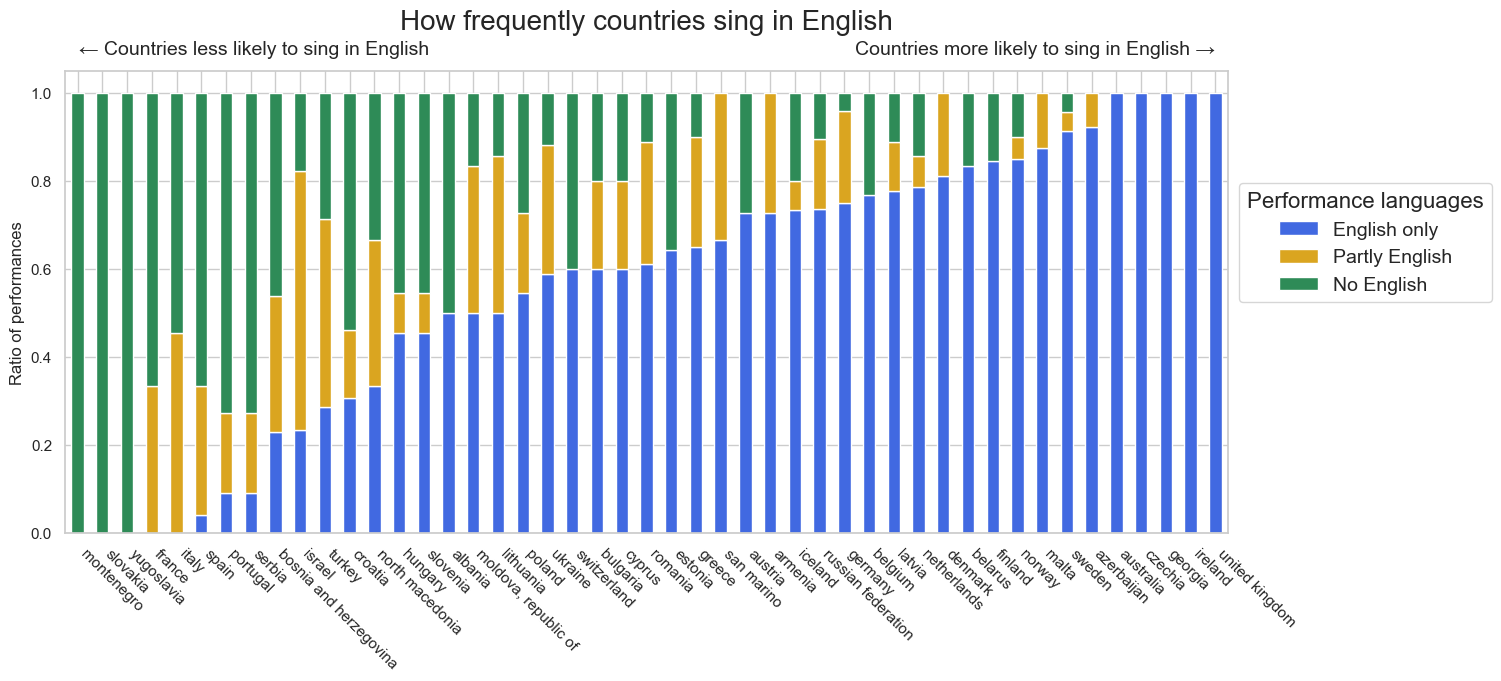

In [25]:
colours = {"English_only":'royalblue', "No_English":'seagreen', "Some_English":'goldenrod'}

df_language.plot(kind='bar', figsize=(15, 6), stacked=True, color=colours)

plt.legend(['English only', 'Partly English', 'No English'], title="Performance languages", loc=[1, 1], 
        fontsize=14,  bbox_to_anchor=(0.51, 0., 0.5, 0.5), title_fontsize=16)

plt.title('How frequently countries sing in English', fontsize=20, pad=30)

plt.text(df_language.shape[0]-1, 1.1, 'Countries more likely to sing in English →', ha='right', va='center', fontsize=14)
plt.text(0.05, 1.1, '← Countries less likely to sing in English ', ha='left', va='center',  fontsize=14)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

plt.show()

In [26]:
# convert wide to long format
df_long = df_performance[['English_only', 'No_English',	'Some_English', 'total_points']]

df_long = df_long.melt(id_vars=['total_points'], var_name='language', value_name='contains_language')

df_long['contains_language'] = df_long['contains_language'].astype(int)

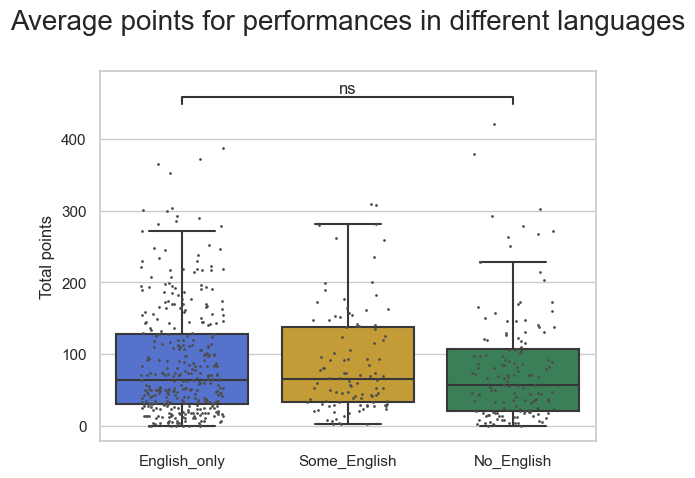

In [27]:
import scipy.stats as stats
from statannot import add_stat_annotation

# boxplots for each language type
ax = sns.boxplot(x='language', y='total_points', 
                 data=df_long.loc[df_long['contains_language'] > 0], 
                 palette=colours, showfliers=False, 
                 order=['English_only', 'Some_English', 'No_English'])
sns.stripplot(x='language', y='total_points', 
              order=['English_only', 'Some_English', 'No_English'],
              data=df_long.loc[df_long['contains_language'] > 0], 
              jitter=0.25, size=2, color=".3", linewidth=0)

plt.title('Average points for performances in different languages', fontsize=20, pad=30)
plt.xlabel('')
plt.ylabel('Total points')

add_stat_annotation(ax, data=df_long.loc[df_long['contains_language'] > 0],
                    x='language', y='total_points', 
                    order=['English_only', 'Some_English', 'No_English'],
                    box_pairs=[("English_only", "No_English")],
                    test='Mann-Whitney', text_format='star', verbose=0)

plt.show()

In [28]:
df_language = df_performance.copy()

df_performance['Own_language'] = (df_performance['Contains_Own_Language']) 
df_performance['Other_language'] = ~df_performance['Contains_Own_Language'] 

# for each country get the ratio of songs that contain only English, some English and no English
# then sort by the ratio of songs that contain only English
df_language = df_performance.groupby('to_country').agg({'Other_language': 'mean', 'Own_language': 'mean'})

df_language = df_language.sort_values(by=['Own_language', 'Other_language'], ascending=True)

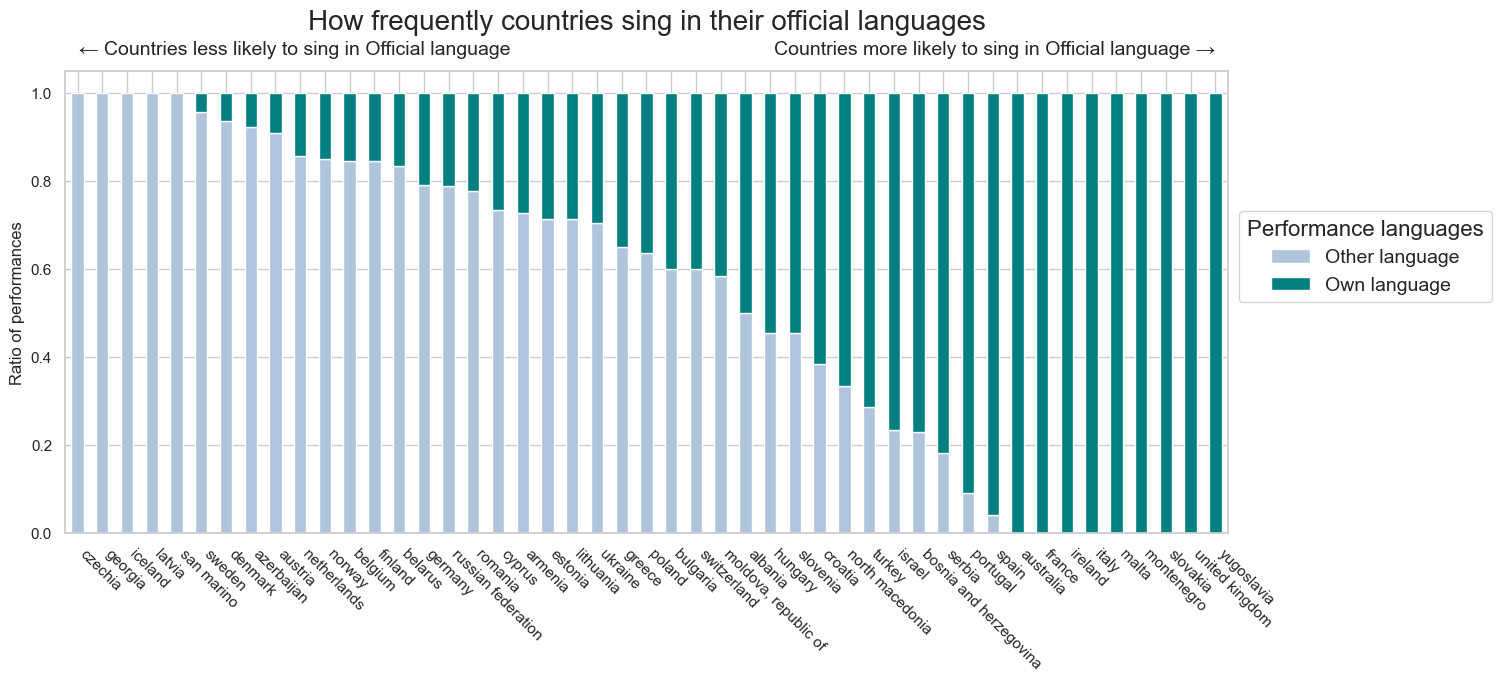

In [29]:
colours = {"Own_language":'teal', "Other_language":'lightsteelblue'}

df_language.plot(kind='bar', figsize=(15, 6), stacked=True, color=colours)

plt.legend(['Other language', 'Own language'], title="Performance languages", loc=[1, 1], 
        fontsize=14,  bbox_to_anchor=(0.51, 0., 0.5, 0.5), title_fontsize=16)

plt.title('How frequently countries sing in their official languages', fontsize=20, pad=30)

plt.text(df_language.shape[0]-1, 1.1, 'Countries more likely to sing in Official language →', ha='right', va='center', fontsize=14)
plt.text(0.05, 1.1, '← Countries less likely to sing in Official language ', ha='left', va='center',  fontsize=14)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')

plt.show()

Typically those on the left of this plot are countries who sing in english but english is not their official language. Those on the right are countries who sing in their official language exclusively.

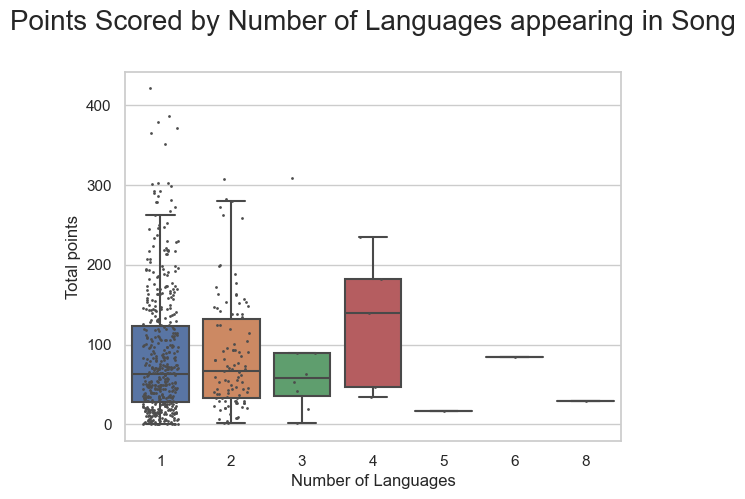

In [30]:
sns.boxplot(x='Number_of_Languages', y='total_points', data=df_performance, showfliers=False)
sns.stripplot(x='Number_of_Languages', y='total_points', data=df_performance, jitter=0.25, size=2, color=".3", linewidth=0)

plt.title('Points Scored by Number of Languages appearing in Song', fontsize=20, pad=30)
plt.xlabel('Number of Languages')
plt.ylabel('Total points')


plt.show()

<Axes: xlabel='Contains_Voting_Language', ylabel='points'>

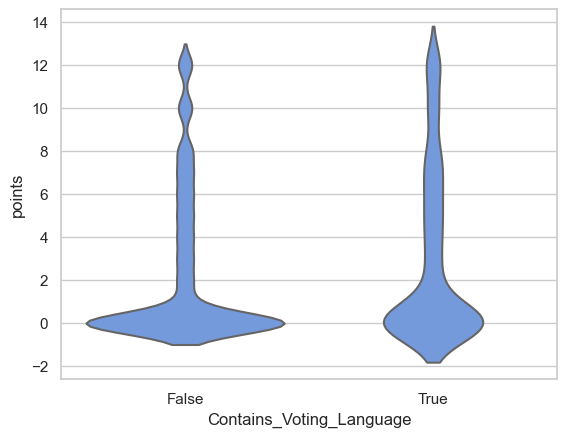

In [31]:
# violin plot
sns.violinplot(x='Contains_Voting_Language', y='points', data=df, inner=None, color="cornflowerblue")

# Gender Data

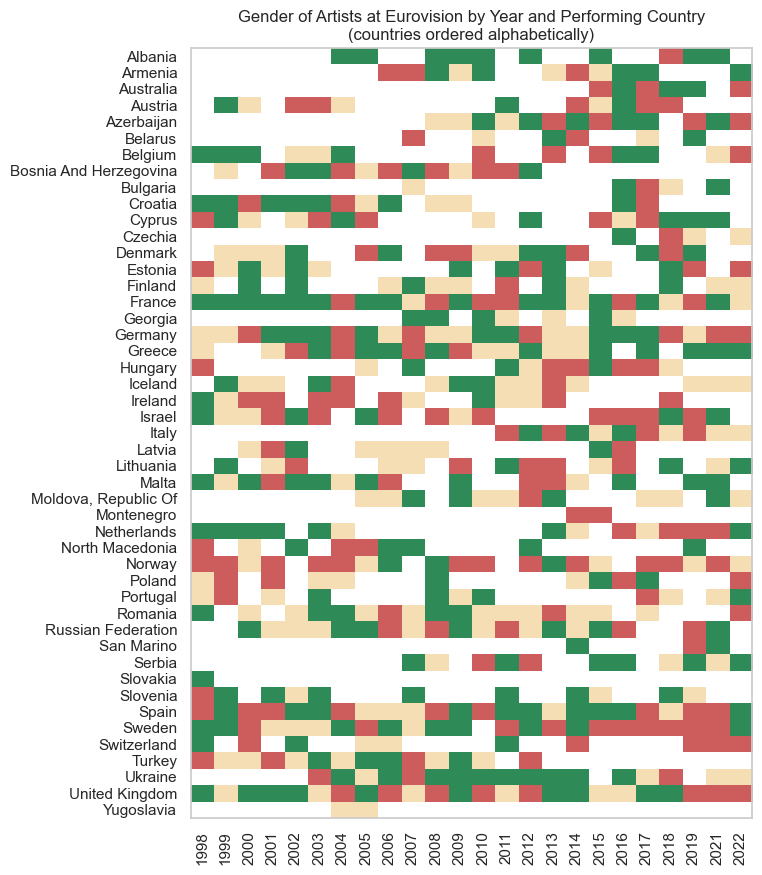

In [32]:
from matplotlib.colors import to_rgba

gender_df = df[['year', 'to_country', 'gender']].copy().drop_duplicates()

countries = gender_df.sort_values(by=['to_country'])['to_country'].drop_duplicates().to_list()
years = gender_df['year'].drop_duplicates().to_list()

gender_colours = {
    'female': to_rgba('seagreen'),
    'group': to_rgba('wheat'),
    'male': to_rgba('indianred'),
    'none': to_rgba('white')
}

gender = []
for year in years:
    missing = pd.DataFrame({'year': [year] * len(countries), 'to_country': countries, 'gender': ['none'] * len(countries)}).set_index('to_country')
    missing.update(gender_df[gender_df['year'] == year].set_index('to_country'))
    gender.append(list(map(lambda x: gender_colours[x], missing.sort_values(by=['to_country'])['gender'].to_list())))

gender = list(map(list, zip(*gender)))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
img = plt.imshow(gender, aspect=0.7)
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years)
plt.xticks(rotation=90)
ax.set_yticks(range(len(countries)))
ax.set_yticklabels(list(map(str.title, countries)))
ax.grid(False)
plt.title('Gender of Artists at Eurovision by Year and Performing Country\n(countries ordered alphabetically)')
plt.show()

In [33]:
for gender in ['female', 'male', 'group']:
    count = len(gender_df[gender_df['gender'] == gender])
    print('Total {} performers: {} ({:.0%})'.format(gender, count, count/len(gender_df)))

def ratio(gender, x): return len([a for a in x if a == gender]) / len(x)

gender_df = gender_df.groupby('to_country').agg(
    female=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('female', x)),
    group=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('group', x)),
    male=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('male', x)),
)
gender_df = gender_df.sort_values(by=['female', 'group'], ascending=False)

gender_df.head()

Total female performers: 240 (40%)
Total male performers: 182 (30%)
Total group performers: 178 (30%)


,female,group,male
to_country,,,
slovakia,1.000000,0.000000,0.000000
albania,0.900000,0.000000,0.100000
san marino,0.666667,0.000000,0.333333
slovenia,0.636364,0.272727,0.090909
ukraine,0.588235,0.235294,0.176471


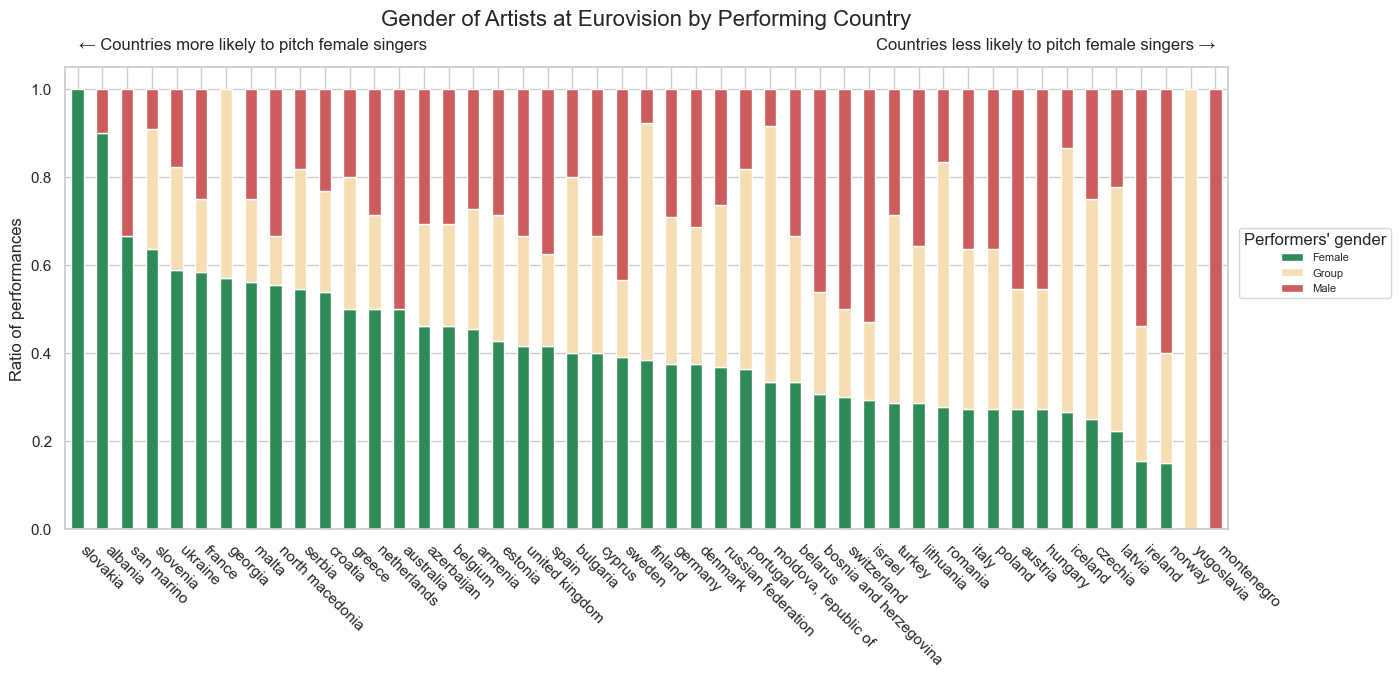

In [34]:
gender_colours = {
    'female': to_rgba('seagreen'),
    'group': to_rgba('wheat'),
    'male': to_rgba('indianred')#,
    #'none': to_rgba('white')
}

gender_df[gender_colours.keys()].plot(kind='bar', figsize=(15, 6), stacked=True, color=gender_colours)
plt.text(gender_df.shape[0] - 1, 1.1, 'Countries less likely to pitch female singers →', ha='right', va='center', fontsize=12)
plt.text(0.05, 1.1, '← Countries more likely to pitch female singers', ha='left', va='center',  fontsize=12)
plt.legend(['Female', 'Group', 'Male'], title="Performers' gender", loc=[1, 1], fontsize=8,  bbox_to_anchor=(0.51, 0., 0.5, 0.5))
plt.title('Gender of Artists at Eurovision by Performing Country', fontsize=16, pad=30)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')
plt.show()

In [35]:
gender_df = df[['year', 'to_code2', 'gender']].copy().drop_duplicates()

def ratio(gender, x): return len([a for a in x if a == gender]) / len(x)

gender_df = gender_df.groupby('year').agg(
    female=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('female', x)),
    group=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('group', x)),
    male=pd.NamedAgg(column='gender', aggfunc=lambda x: ratio('male', x)),
)

gender_df.head()

,female,group,male
year,,,
1998,0.480000,0.200000,0.320000
1999,0.478261,0.391304,0.130435
2000,0.333333,0.416667,0.250000
2001,0.260870,0.347826,0.391304
2002,0.583333,0.291667,0.125000


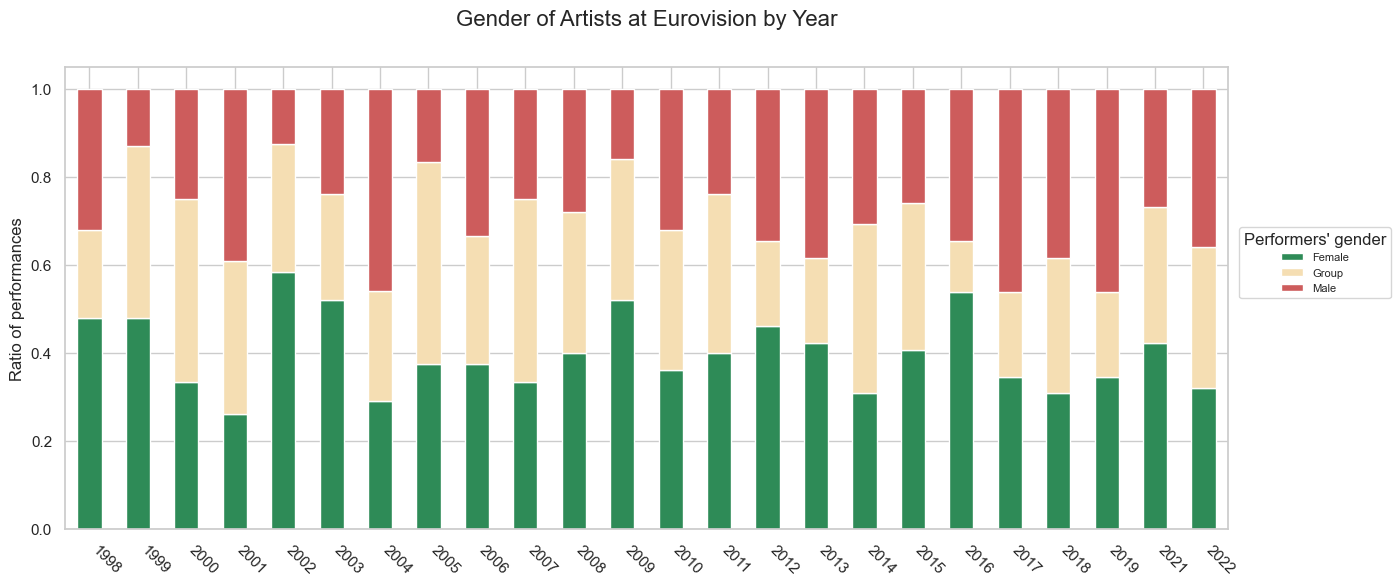

In [36]:
# subset gender_colours to genders in gender_df columns
# gender_colours = gender_colours[gender_df.columns.to_list()]

gender_df.plot(kind='bar', figsize=(15, 6), stacked=True, color=gender_colours)

plt.legend(['Female', 'Group', 'Male'], title="Performers' gender", loc=[1, 1], fontsize=8,  bbox_to_anchor=(0.51, 0., 0.5, 0.5))
plt.title('Gender of Artists at Eurovision by Year', fontsize=16, pad=30)
plt.xticks(rotation=-45, ha='left')
plt.xlabel('')
plt.ylabel('Ratio of performances')
plt.show()

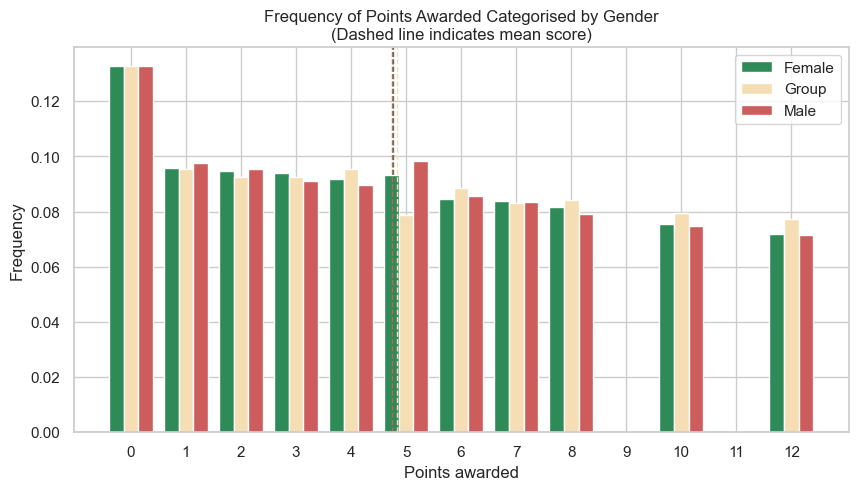

In [39]:
gender_df = df[['year', 'to_code2', 'gender', 'points']].copy().drop_duplicates()
genders = list(gender_colours.keys())[:3]
votes = []
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
for gender in genders:
    votes_df = gender_df[gender_df['gender'] == gender]['points']
    votes.append(votes_df)
    plt.axvline(votes_df.mean(), color=gender_colours[gender], linestyle='dashed', linewidth=1)

plt.hist(votes, density=True, bins=range(14), color=list(gender_colours.values())[:3], label=[gender.title() for gender in genders], align='left')
plt.xlabel('Points awarded')
plt.ylabel('Frequency')
plt.title('Frequency of Points Awarded Categorised by Gender\n(Dashed line indicates mean score)')
plt.legend()
plt.xticks(range(13))
ax.set_xticklabels([str(i) for i in range(13)])
plt.show()

In [67]:
# TODO: check if male get higher average votes. 

# Collective Visualisations

- Heatmap for correlation plot
- Martin's plot
- Geographical plots
- Scatter plots

In [40]:
df_performance = df[['year', 'Artist', 'to_country', 
       'total_points', 'rank', 'to_code2', 
       'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'prop_emigrants_v2p', 'prop_emigrants_p2v', 'has_border',
       'comps_without_win',
       'Number_of_Languages', 'Contains_Own_Language', 'gender']].drop_duplicates()

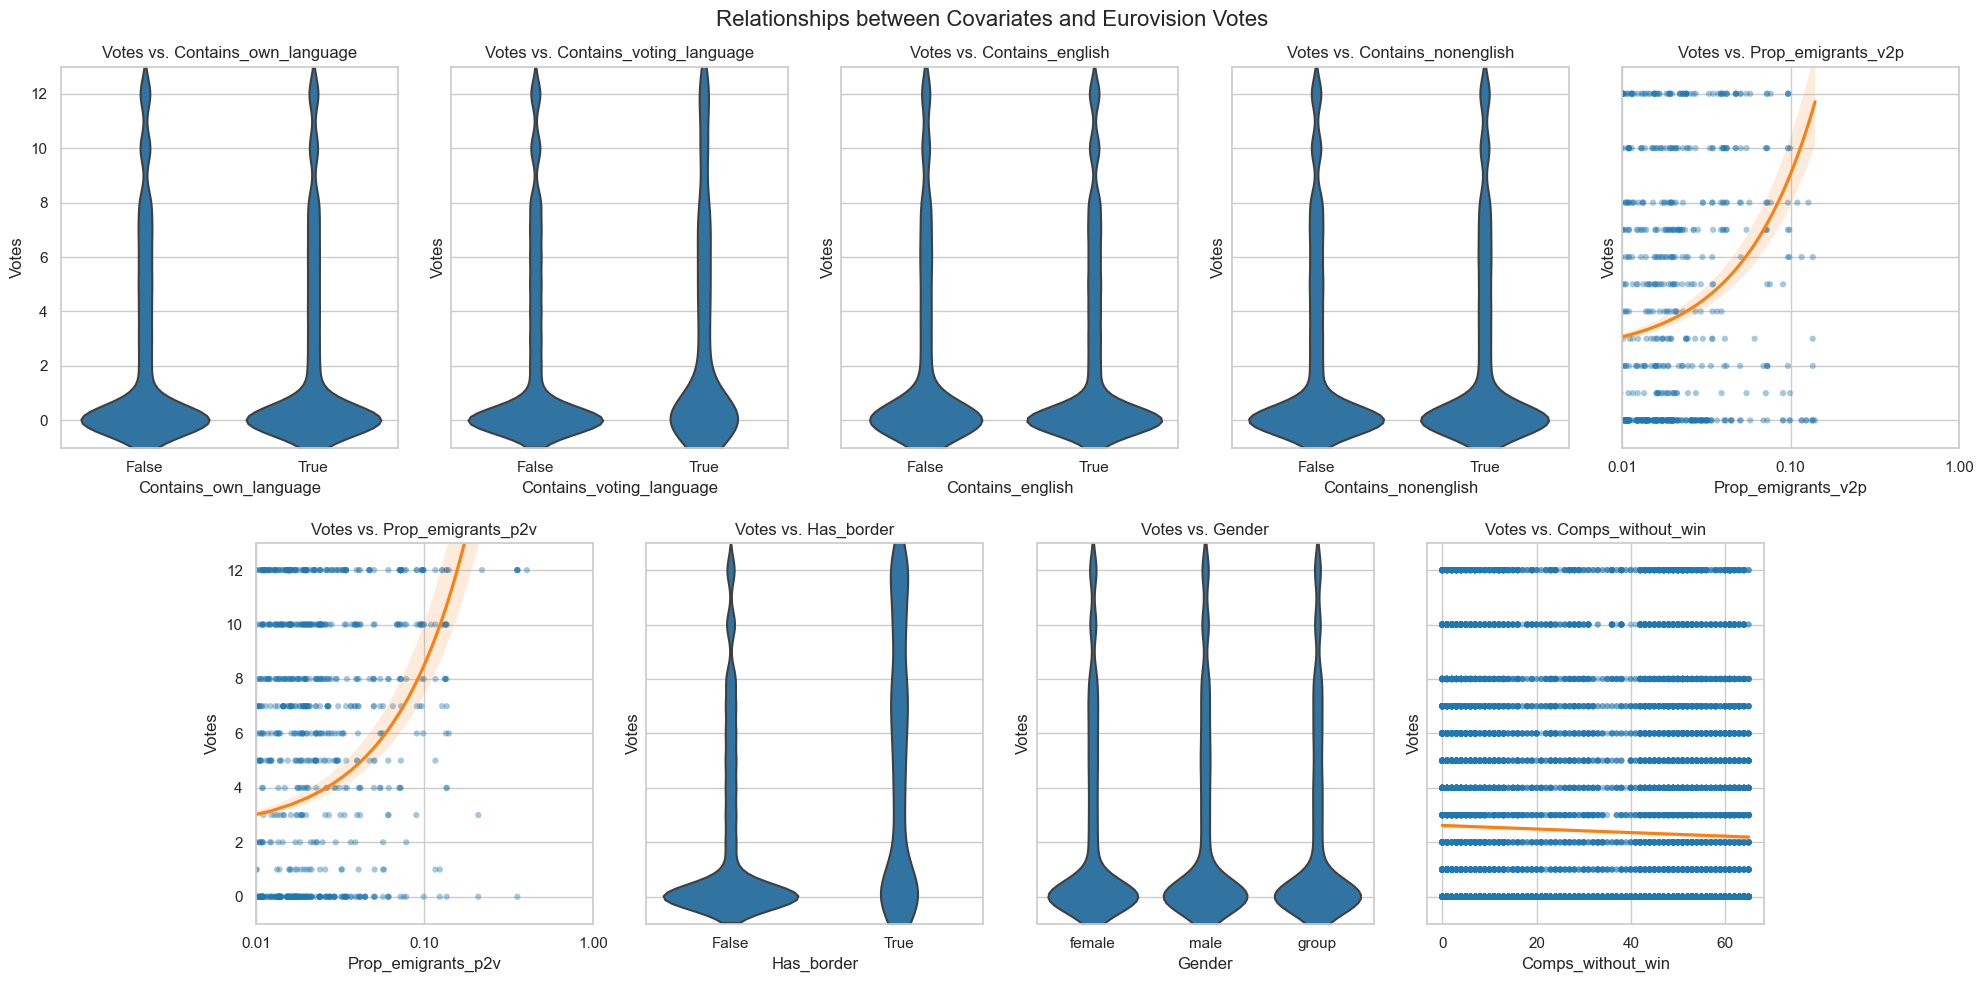

In [112]:
import matplotlib

# Define the variables of interest and their data types
vars_of_interest = {
    'Contains_Own_Language': 'binary',
    'Contains_Voting_Language': 'binary',
    'Contains_English': 'binary',
    'Contains_NonEnglish': 'binary',
    'prop_emigrants_v2p': 'numeric', 
    'prop_emigrants_p2v': 'numeric', 
    'has_border': 'binary',
    'gender': 'categorical', 
    'comps_without_win': 'numeric'
}

# Define the figure and axes
nc = int(np.ceil(len(vars_of_interest)/2))
fig, axes = plt.subplots(nrows=2, ncols=nc, figsize=(20, 10), sharey=True)

# Loop through the dictionary
for i, (key, value) in enumerate(vars_of_interest.items()):
    j, k = 0, i
    if i > (nc - 1):
        j, k = 1, i - nc

    if value == 'categorical':
        sns.violinplot(ax=axes[j, k], x=key, y='points', data=df, color='tab:blue', inner=None, showmeans=True)
    elif value == 'binary':
        sns.violinplot(ax=axes[j, k], x=key, y='points', data=df, color='tab:blue', inner=None, showmeans=True)
    else:
        sns.regplot(ax=axes[j, k], x=key, y='points', data=df, ci=95, 
                    color='tab:blue', scatter_kws={'alpha': 0.4, 'edgecolor': 'none', 's': 20}, 
                    line_kws={'color': 'tab:orange'})

        # if key contains Prop then log scale x axis
        if key.startswith('prop'):
            axes[j, k].set_xscale('log')
            axes[j, k].set_xticks([0.01, 0.1, 1, 10, 100])
            axes[j, k].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            axes[j, k].set_xlim(0.01, 1)

    axes[j, k].set_ylim(-1, 13)
    axes[j, k].set_xlabel(key.capitalize())
    axes[j, k].set_ylabel('Votes')
    axes[j, k].set_title(f'Votes vs. {key.capitalize()}')

fig.suptitle('Relationships between Covariates and Eurovision Votes', fontsize=16)

fig.tight_layout()
fig.subplots_adjust(hspace=0.25)

# Shuffle the bottom row along there are an odd number of variables
if len(vars_of_interest) % 2 == 1:
    axes[1][-1].remove()
    # distance between two axes
    if len(vars_of_interest) >= 3:
        dist = axes[0][1].get_position().x0 - axes[0][0].get_position().x0
        for ax in axes[1]:
            pos = ax.get_position()
            ax.set_position([pos.x0 + (dist / 2), pos.y0, pos.width, pos.height])

plt.show()

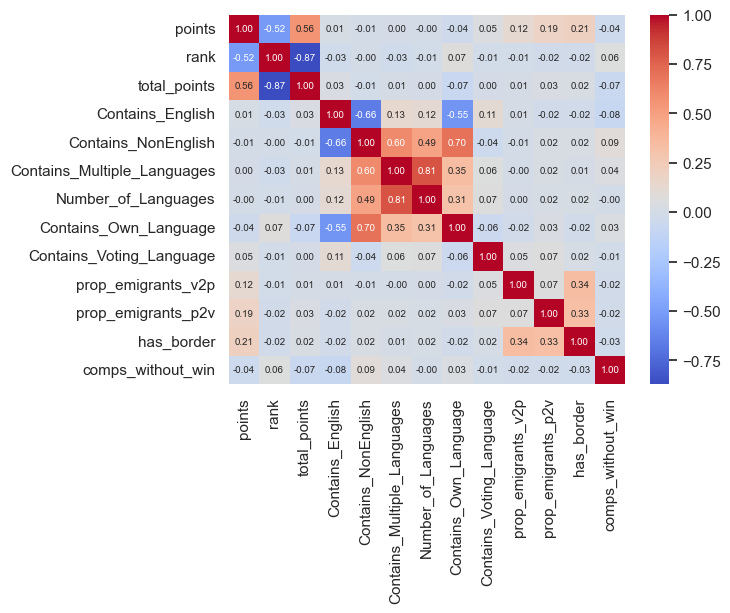

In [116]:
# correlation plot of numeric and binary variables
df_corr = df[['to_country', 'from_country', 'points', 'rank',
       'total_points', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'Contains_Voting_Language',
       'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v', 'has_border',
       'comps_without_win']].drop_duplicates()

# heatmap of the correlation matrix
sns.heatmap(df_corr.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'fontsize': 7})
plt.show()

## Naive predictions

In [43]:
# Get maximum rank in each year
df_rank_max = (df[['year', 'rank']]
              .groupby('year')
              .agg('max')
              .rename({'rank': 'rank_max'}, axis=1)
              )
df_rank_max.head()

,rank_max
year,
1998,25.0
1999,23.0
2000,24.0
2001,23.0
2002,24.0


In [44]:
# Calculate average rank for each country
df_rank = (df[['to_code2', 'year', 'rank', 'total_points']]
              .drop_duplicates()
              .join(df_rank_max, how='left', on='year')
              .assign(rank_inverse=lambda x: x['rank_max'] - x['rank'])
              .groupby('to_code2')
              .agg({'rank_inverse': ['mean', 'count'], 'total_points': 'mean'})
)
df_rank.columns = ['_'.join(col) for col in df_rank.columns]
df_rank = df_rank.rename({'rank_inverse_count': 'count'}, axis=1)
df_rank.head()

,rank_inverse_mean,count,total_points_mean
to_code2,,,
AL,11.700000,10,68.500000
AM,14.545455,11,103.363636
AT,11.727273,11,83.272727
AU,16.166667,6,138.333333
AZ,15.615385,13,116.615385


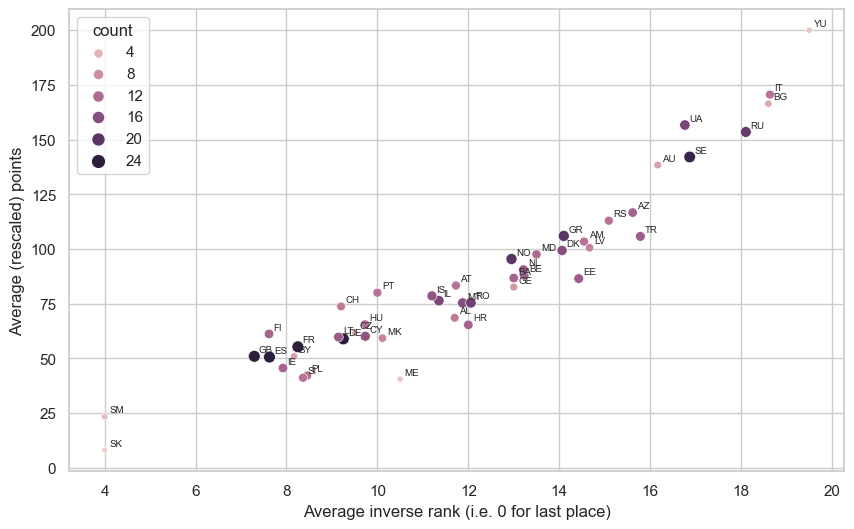

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='rank_inverse_mean', y='total_points_mean', data=df_rank, ax=ax, hue='count', size='count')
for i, s in df_rank.iterrows():
    ax.annotate(i, (s['rank_inverse_mean'] + 0.1, s['total_points_mean'] + 1), fontsize=7, ha='left', va='bottom')
ax.set(xlabel='Average inverse rank (i.e. 0 for last place)', ylabel='Average (rescaled) points')
plt.show()

In [46]:
df_2023 = pd.read_csv('../../data/df_2023.csv')
countries_2023 = df_2023['to_code2'].unique()
df_rank_2023 = df_rank.query('to_code2 in @countries_2023')

sums = df_rank_2023.sum()
df_rank_2023 = (df_rank_2023.assign(rank_win_pct=lambda x: x['rank_inverse_mean'] / sums['rank_inverse_mean'],
                    pts_win_pct=lambda x: x['total_points_mean'] / sums['total_points_mean'])
                    .sort_values(by='pts_win_pct', ascending=True)
                    .reset_index()
)
df_rank_2023.head(n=20)

,to_code2,rank_inverse_mean,count,total_points_mean,rank_win_pct,pts_win_pct
0,SM,4.000000,3,23.333333,0.010891,0.009221
1,SI,8.363636,11,41.090909,0.022772,0.016239
2,PL,8.454545,11,42.090909,0.023019,0.016634
3,IE,7.923077,13,45.538462,0.021572,0.017996
4,LT,9.142857,14,59.714286,0.024893,0.023598
5,CY,9.733333,15,60.066667,0.026501,0.023738
6,FI,7.615385,13,61.153846,0.020734,0.024167
7,CZ,9.500000,4,61.750000,0.025866,0.024403
8,HR,12.000000,13,65.307692,0.032672,0.025809
9,AL,11.700000,10,68.500000,0.031855,0.027070


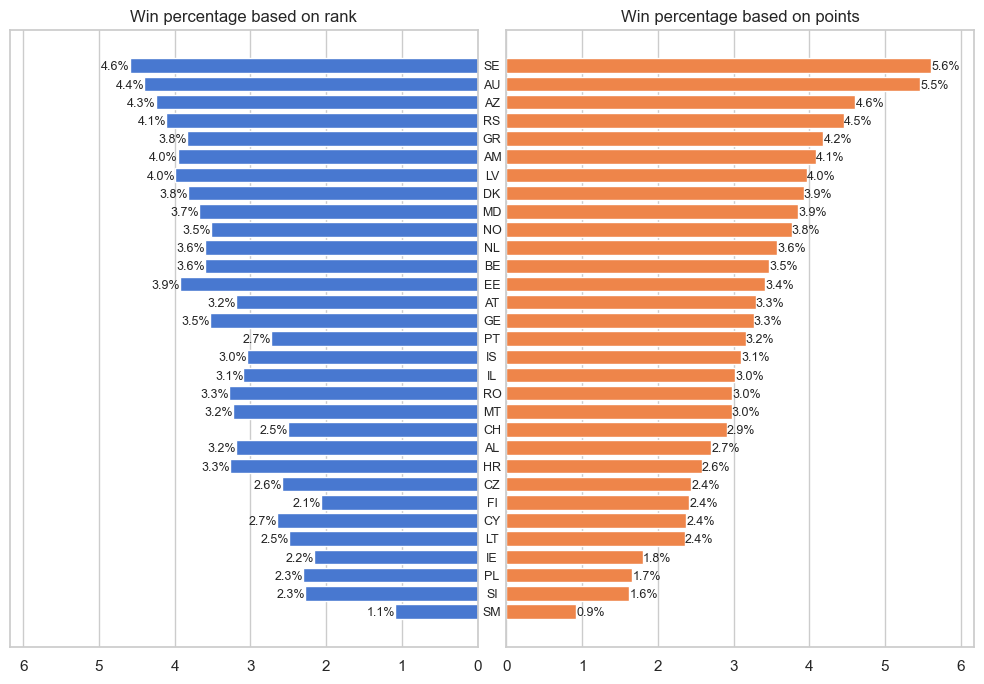

In [118]:
# Plot both side by side.
# This code can be reused, if we're comparing two different win rate predictions; you only need to change the first four lines

# Input data. These should belong to the same dataframe as we're assuming that they are ordered in the same way
idx = df_rank_2023.index
countries = df_rank_2023['to_code2']   # used as labels
data1 = df_rank_2023['rank_win_pct'] * 100
data2 = df_rank_2023['pts_win_pct'] * 100

# Set up axes and plot data
fig, axs = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
axs[0].barh(y=idx, width=data1, color='#4878D0')
axs[1].barh(y=idx, width=data2, color='#EE854A')
axs[0].set_title('Win percentage based on rank')
axs[1].set_title('Win percentage based on points')
for ax in axs:
    ymax = max(data1.max(), data2.max()) * 1.1   # extra space for labels
    ax.set(xlim=(0, ymax), yticks=[], yticklabels=[])
axs[0].invert_xaxis()

# Add labels
# x-coordinate is in figure coordinates; y-coordinate in axis data. Because of sharey it doesn't matter which set of Axes we use.
tfm = matplotlib.transforms.blended_transform_factory(fig.transFigure, axs[0].transData)
for i, (cty, dp1, dp2) in enumerate(zip(countries, data1, data2)):
    yadjust = -0.09  # just to centre the labels exactly (I don't really know why it doesn't do that already)
    axs[0].text(x=dp1, y=i+yadjust, s=f'{dp1:.1f}%', ha='right', va='center', fontsize=9)
    axs[1].text(x=dp2, y=i+yadjust, s=f'{dp2:.1f}%', ha='left', va='center', fontsize=9)
    axs[0].text(x=0.5, y=i+yadjust, s=cty, ha='center', va='center', fontsize=9, transform=tfm)
fig.subplots_adjust(wspace=0.05)
fig.tight_layout()
plt.show()